In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import math
import random

def extract_normalized_color_histogram(patch, bins=8):
    hist_features = []
    num_pixels = patch.shape[0] * patch.shape[1]
    for channel in range(3):
        channel_data = patch[:, :, channel]
        hist, _ = np.histogram(channel_data, bins=bins, range=(0, 256))
        hist = hist / num_pixels
        hist_features.extend(hist)
    return np.array(hist_features)

def process_images_in_folder(folder_path, class_folders):
    data = {}
    for class_folder in class_folders:
        class_path = os.path.join(folder_path, class_folder)
        class_data = []
        if not os.path.isdir(class_path):
            continue
        for image_file in os.listdir(class_path):
            image_path = os.path.join(class_path, image_file)
            try:
                image = Image.open(image_path).convert('RGB')
            except:
                continue
            image = np.array(image)
            patches = []
            for y in range(0, image.shape[0], 32):
                for x in range(0, image.shape[1], 32):
                    patch = image[y:y+32, x:x+32]
                    if patch.shape[0] == 32 and patch.shape[1] == 32:
                        patch_hist = extract_normalized_color_histogram(patch)
                        patches.append(patch_hist)
            if patches:
                class_data.append(np.stack(patches))
        data[class_folder] = class_data
    return data

def initialize_centroids(data, K):
    indices = np.random.choice(data.shape[0], K, replace=False)
    centroids = data[indices]
    return centroids

def assign_clusters(data, centroids):
    distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)
    assignments = np.argmin(distances, axis=1)
    return assignments

def update_centroids(data, assignments, K):
    D = data.shape[1]
    new_centroids = np.zeros((K, D))
    for k in range(K):
        assigned_data = data[assignments == k]
        if len(assigned_data) > 0:
            new_centroids[k] = assigned_data.mean(axis=0)
        else:
            new_centroids[k] = data[np.random.choice(data.shape[0])]
    return new_centroids

def kmeans(data, K, max_iters=100, tol=1e-4):
    centroids = initialize_centroids(data, K)
    for i in range(max_iters):
        assignments = assign_clusters(data, centroids)
        new_centroids = update_centroids(data, assignments, K)
        shift = np.linalg.norm(new_centroids - centroids)
        if shift < tol:
            break
        centroids = new_centroids
    return centroids, assignments, i+1

def perform_kmeans_on_train_data(train_data, K):
    class_centroids = {}
    class_assignments = {}
    class_iterations = {}
    for cls, images in train_data.items():
        aggregated_patches = np.vstack(images)
        np.random.shuffle(aggregated_patches)
        centroids, assignments, iterations = kmeans(aggregated_patches, K)
        class_centroids[cls] = centroids
        class_assignments[cls] = assignments
        class_iterations[cls] = iterations
    return class_centroids, class_assignments, class_iterations

def gaussian_pdf(x, mean, covariance):
    size = len(x)
    det_cov = np.linalg.det(covariance)
    det_cov = max(det_cov, 1e-6)
    norm_const = 1.0 / (math.pow((2 * math.pi), size / 2) * math.sqrt(det_cov))
    x_mu = x - mean
    inv_cov = np.linalg.inv(covariance + 1e-6 * np.eye(len(mean)))
    result = math.exp(-0.5 * np.dot(np.dot(x_mu, inv_cov), x_mu))
    return norm_const * result

def e_step(data, means, covariances, weights, K):
    N = data.shape[0]
    responsibilities = np.zeros((N, K))
    for k in range(K):
        for n in range(N):
            responsibilities[n, k] = weights[k] * gaussian_pdf(data[n], means[k], covariances[k])
    responsibilities[responsibilities.sum(axis=1) == 0] = 1.0 / K
    responsibilities /= responsibilities.sum(axis=1, keepdims=True)
    return responsibilities

def m_step(data, responsibilities, K):
    N, D = data.shape
    Nk = np.sum(responsibilities, axis=0)
    means = np.dot(responsibilities.T, data) / Nk[:, np.newaxis]
    covariances = np.zeros((K, D, D))
    for k in range(K):
        diff = data - means[k]
        covariances[k] = np.dot((responsibilities[:, k][:, np.newaxis] * diff).T, diff) / Nk[k]
        covariances[k] += 1e-6 * np.eye(D)
    weights = Nk / N
    return means, covariances, weights

def compute_log_likelihood(data, means, covariances, weights, K):
    log_likelihood = 0.0
    for n in range(data.shape[0]):
        likelihood_n = 0.0
        for k in range(K):
            likelihood_n += weights[k] * gaussian_pdf(data[n], means[k], covariances[k])
        log_likelihood += np.log(max(likelihood_n, 1e-8))
    return log_likelihood

def em_algorithm(data, initial_means, initial_covariances, initial_weights, K, max_iters=100, tol=1e-4):
    means = initial_means.copy()
    covariances = initial_covariances.copy()
    weights = initial_weights.copy()
    log_likelihoods = []
    for i in range(max_iters):
        responsibilities = e_step(data, means, covariances, weights, K)
        means, covariances, weights = m_step(data, responsibilities, K)
        log_likelihood = compute_log_likelihood(data, means, covariances, weights, K)
        log_likelihoods.append(log_likelihood)
        if i > 0 and abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
            break
    return means, covariances, weights, log_likelihoods, i+1

def train_gmms(train_data, class_centroids, class_assignments, K, max_iters=100, tol=1e-4):
    class_gmms = {}
    class_log_likelihoods = {}
    class_iterations = {}
    for cls in train_data.keys():
        aggregated_patches = np.vstack(train_data[cls])
        assignments = class_assignments[cls]
        means_init = class_centroids[cls]
        covariances_init = np.zeros((K, aggregated_patches.shape[1], aggregated_patches.shape[1]))
        for k in range(K):
            assigned_data = aggregated_patches[assignments == k]
            cov = np.cov(assigned_data.T) if len(assigned_data) > 1 else np.eye(aggregated_patches.shape[1])
            covariances_init[k] = cov + 1e-6 * np.eye(aggregated_patches.shape[1])
        weights_init = np.array([np.mean(assignments == k) for k in range(K)])
        means, covariances, weights, log_likelihoods, iterations = em_algorithm(
            aggregated_patches,
            means_init,
            covariances_init,
            weights_init,
            K,
            max_iters,
            tol
        )
        class_gmms[cls] = {'means': means, 'covariances': covariances, 'weights': weights}
        class_log_likelihoods[cls] = log_likelihoods
        class_iterations[cls] = iterations
    return class_gmms, class_log_likelihoods, class_iterations

def classify_image(image_patches, class_gmms, K):
    class_scores = {}
    for cls, gmm in class_gmms.items():
        log_likelihood = 0.0
        for patch in image_patches:
            patch_prob = 0.0
            for k in range(K):
                prob = gmm['weights'][k] * gaussian_pdf(patch, gmm['means'][k], gmm['covariances'][k])
                patch_prob += prob
            log_likelihood += np.log(max(patch_prob, 1e-8))
        class_scores[cls] = log_likelihood
    predicted_class = max(class_scores, key=class_scores.get)
    return predicted_class, class_scores

def evaluate_classifier(test_data, class_gmms, K):
    true_labels = []
    predicted_labels = []
    for cls, images in test_data.items():
        for image_patches in images:
            predicted_class, _ = classify_image(image_patches, class_gmms, K)
            true_labels.append(cls)
            predicted_labels.append(predicted_class)
    return true_labels, predicted_labels

def compute_accuracy(true_labels, predicted_labels):
    correct = sum(t == p for t, p in zip(true_labels, predicted_labels))
    return correct / len(true_labels)

def compute_confusion_matrix(true_labels, predicted_labels, class_labels):
    num_classes = len(class_labels)
    matrix = np.zeros((num_classes, num_classes), dtype=int)
    label_to_index = {label: idx for idx, label in enumerate(class_labels)}
    for true_label, predicted_label in zip(true_labels, predicted_labels):
        true_idx = label_to_index[true_label]
        pred_idx = label_to_index[predicted_label]
        matrix[true_idx, pred_idx] += 1
    return matrix


Processing training data...
Processing testing data...

Starting K-Means Clustering on Training Data...


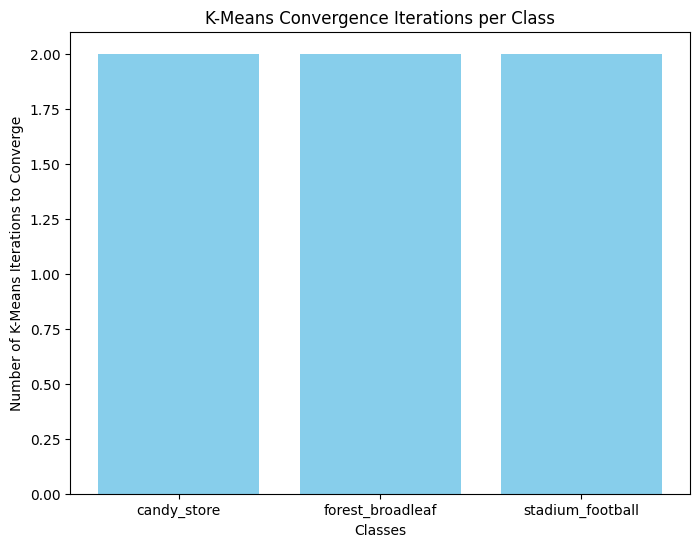


Starting GMM Training with EM Algorithm...

Classifying Test Images...

Classification Accuracy: 58.67%

Confusion Matrix:
                                    Predicted
               candy_store forest_broadleaf stadium_football
candy_store    37         0          13        
forest_broadleaf12         6          32        
stadium_football5          0          45        

Precision and Recall per Class:
candy_store: Precision = 0.69, Recall = 0.74
forest_broadleaf: Precision = 1.00, Recall = 0.12
stadium_football: Precision = 0.50, Recall = 0.90


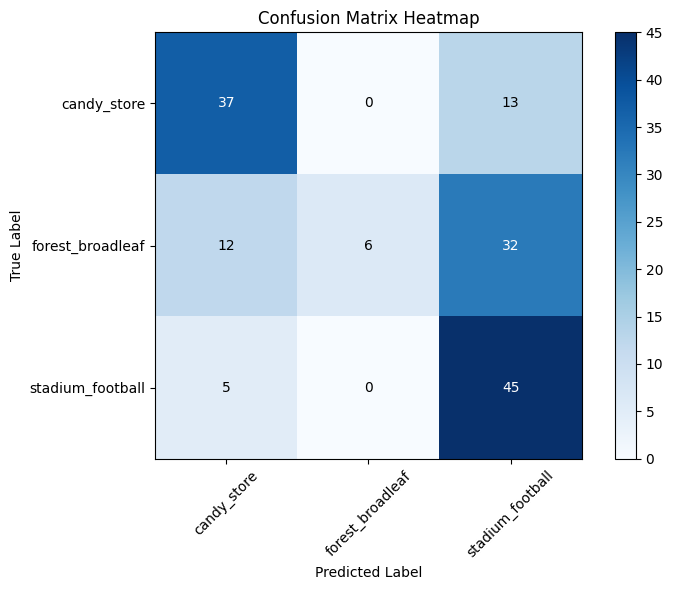

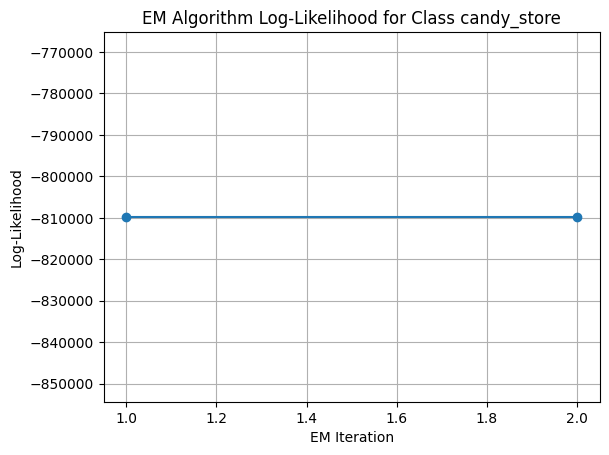

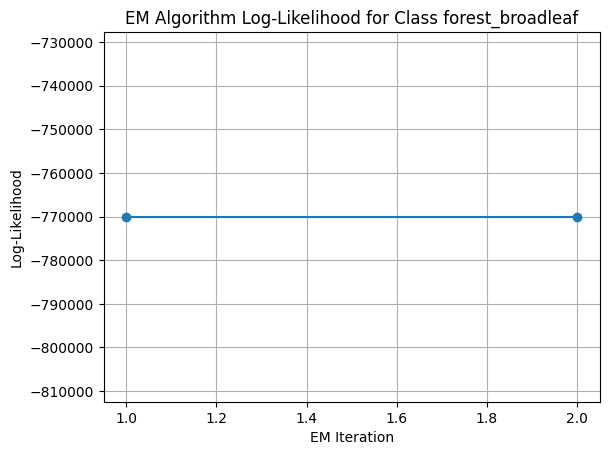

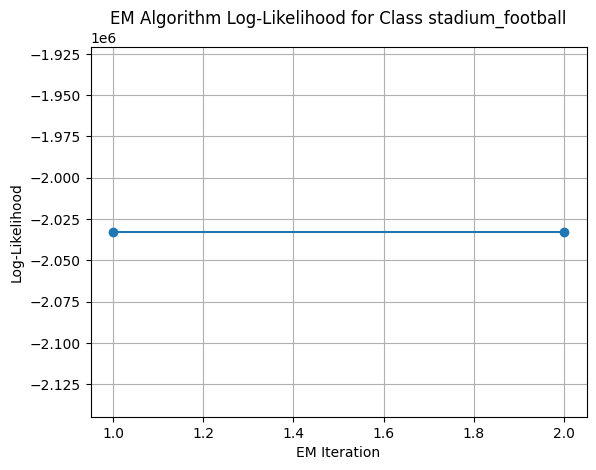

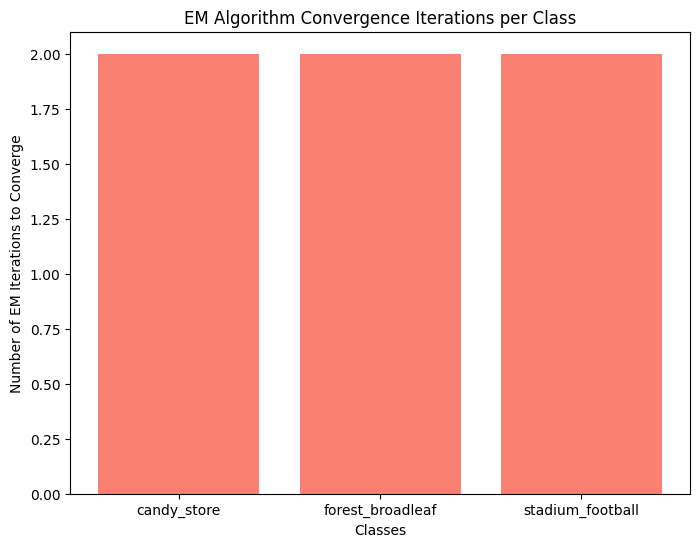

In [2]:
def compute_precision_recall(confusion_matrix):
    precision = []
    recall = []
    for i in range(confusion_matrix.shape[0]):
        tp = confusion_matrix[i, i]
        fp = confusion_matrix[:, i].sum() - tp
        fn = confusion_matrix[i, :].sum() - tp
        prec = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        rec = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        precision.append(prec)
        recall.append(rec)
    return precision, recall

def plot_confusion_matrix_heatmap(confusion_matrix, classes):
    plt.figure(figsize=(8, 6))
    plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix Heatmap')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = 'd'
    thresh = confusion_matrix.max() / 2.
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            plt.text(j, i, format(confusion_matrix[i, j], fmt),
                     ha="center", va="center",
                     color="white" if confusion_matrix[i, j] > thresh else "black")
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

def main():
    # Define paths and classes
    train_folder = 'train'
    test_folder = 'test'
    class_folders = ['candy_store', 'forest_broadleaf', 'stadium_football']
    
    # Process training and testing data
    print("Processing training data...")
    train_data = process_images_in_folder(train_folder, class_folders)
    print("Processing testing data...")
    test_data = process_images_in_folder(test_folder, class_folders)
    
    # Define number of clusters/GMM components
    K = 1 # You can adjust this based on your data
    
    # Perform K-Means clustering on training data
    print("\nStarting K-Means Clustering on Training Data...")
    class_centroids, class_assignments, class_iterations = perform_kmeans_on_train_data(train_data, K)
    
    # Plot K-Means iterations per class
    classes = list(class_iterations.keys())
    iterations = list(class_iterations.values())
    
    plt.figure(figsize=(8, 6))
    plt.bar(classes, iterations, color='skyblue')
    plt.xlabel('Classes')
    plt.ylabel('Number of K-Means Iterations to Converge')
    plt.title('K-Means Convergence Iterations per Class')
    plt.show()
    
    # Train GMMs using the EM algorithm
    print("\nStarting GMM Training with EM Algorithm...")
    class_gmms, class_log_likelihoods, class_em_iterations = train_gmms(
        train_data,
        class_centroids,
        class_assignments,
        K,
        max_iters=100,
        tol=1e-4
    )
    
    # Classify test images
    print("\nClassifying Test Images...")
    true_labels, predicted_labels = evaluate_classifier(test_data, class_gmms, K)
    
    # Define class names
    classes = ['candy_store', 'forest_broadleaf', 'stadium_football']
    
    # Compute Evaluation Metrics
    accuracy = compute_accuracy(true_labels, predicted_labels)
    conf_matrix = compute_confusion_matrix(true_labels, predicted_labels, classes)
    precision, recall = compute_precision_recall(conf_matrix)
    
    # Display Metrics
    print(f"\nClassification Accuracy: {accuracy * 100:.2f}%\n")
    
    print("Confusion Matrix:")
    print(f"{'':15}{'Predicted':>30}")
    header = ' '.join([cls.ljust(10) for cls in classes])
    print(f"{'':15}{header}")
    for i, cls in enumerate(classes):
        row = ' '.join([str(conf_matrix[i, j]).ljust(10) for j in range(len(classes))])
        print(f"{cls.ljust(15)}{row}")
    
    print("\nPrecision and Recall per Class:")
    for i, cls in enumerate(classes):
        print(f"{cls}: Precision = {precision[i]:.2f}, Recall = {recall[i]:.2f}")
    
    # Plot Confusion Matrix Heatmap
    plot_confusion_matrix_heatmap(conf_matrix, classes)
    
    # Plot EM Log-Likelihoods for each class
    for cls, log_likelihood in class_log_likelihoods.items():
        plt.figure()
        plt.plot(range(1, len(log_likelihood)+1), log_likelihood, marker='o')
        plt.xlabel('EM Iteration')
        plt.ylabel('Log-Likelihood')
        plt.title(f'EM Algorithm Log-Likelihood for Class {cls}')
        plt.grid(True)
        plt.show()
    
    # Plot EM iterations per class
    plt.figure(figsize=(8, 6))
    plt.bar(classes, list(class_em_iterations.values()), color='salmon')
    plt.xlabel('Classes')
    plt.ylabel('Number of EM Iterations to Converge')
    plt.title('EM Algorithm Convergence Iterations per Class')
    plt.show()

if __name__ == "__main__":
    main()

Processing training data...
Processing testing data...
For K value  2

Starting K-Means Clustering on Training Data...


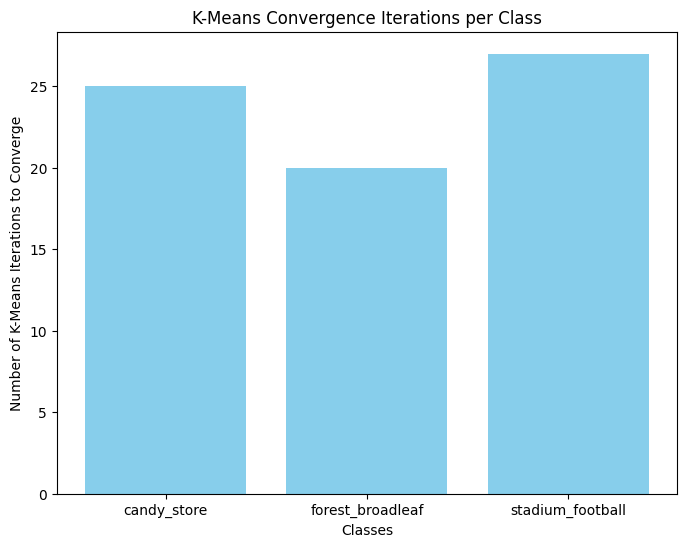


Starting GMM Training with EM Algorithm...

Classifying Test Images...

Classification Accuracy: 59.33%

Confusion Matrix:
                                    Predicted
               candy_store forest_broadleaf stadium_football
candy_store    34         0          16        
forest_broadleaf10         9          31        
stadium_football4          0          46        

Precision and Recall per Class:
candy_store: Precision = 0.71, Recall = 0.68
forest_broadleaf: Precision = 1.00, Recall = 0.18
stadium_football: Precision = 0.49, Recall = 0.92


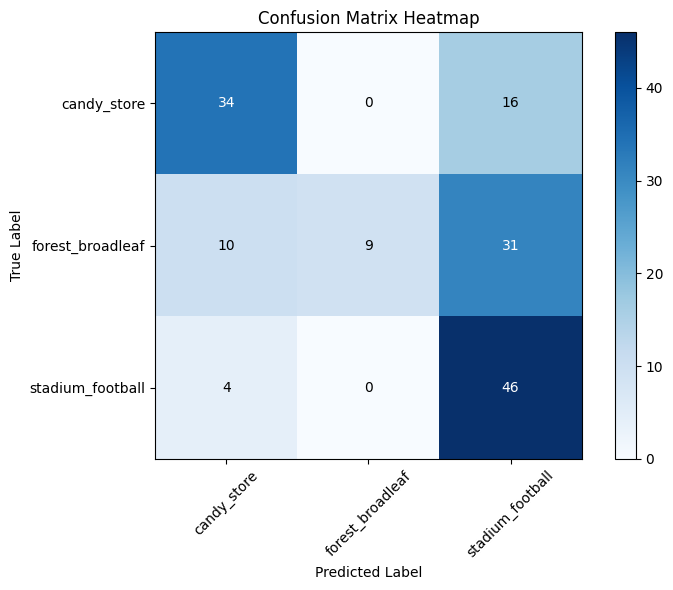

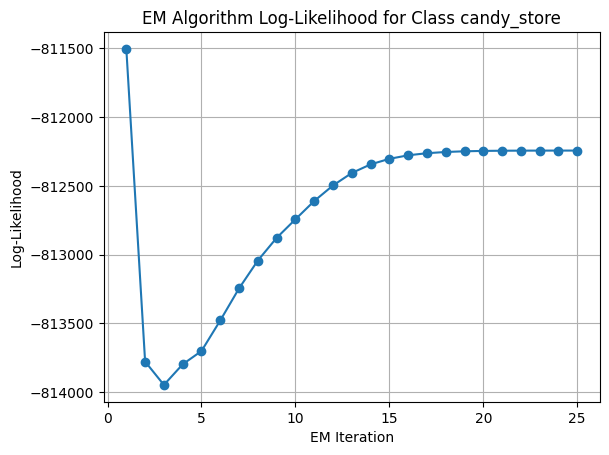

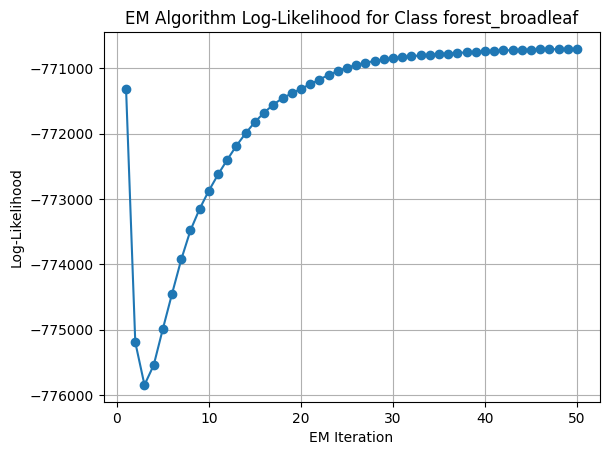

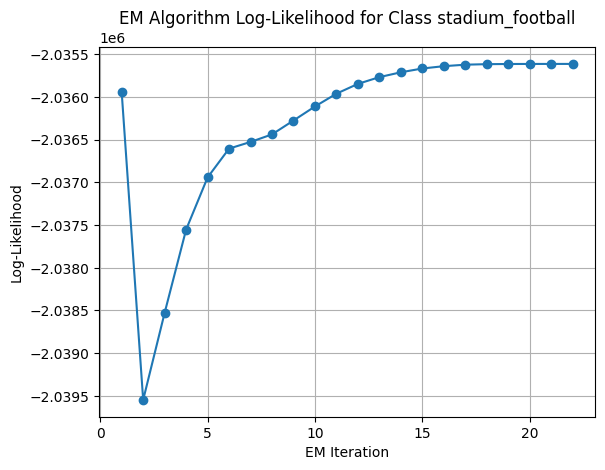

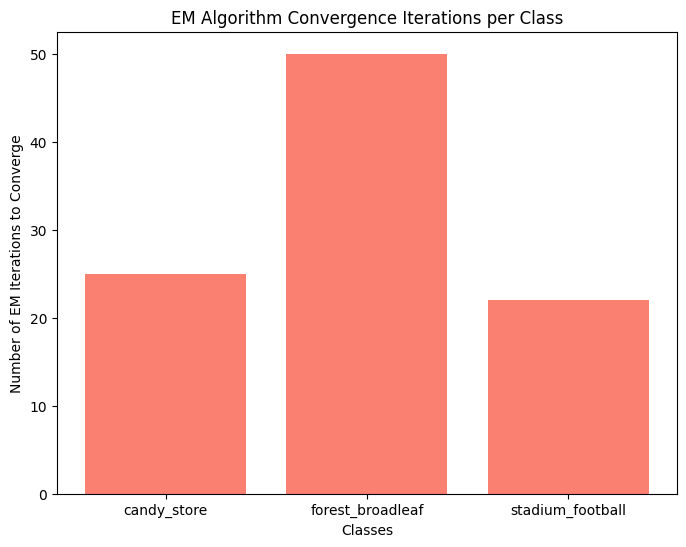

For K value  4

Starting K-Means Clustering on Training Data...


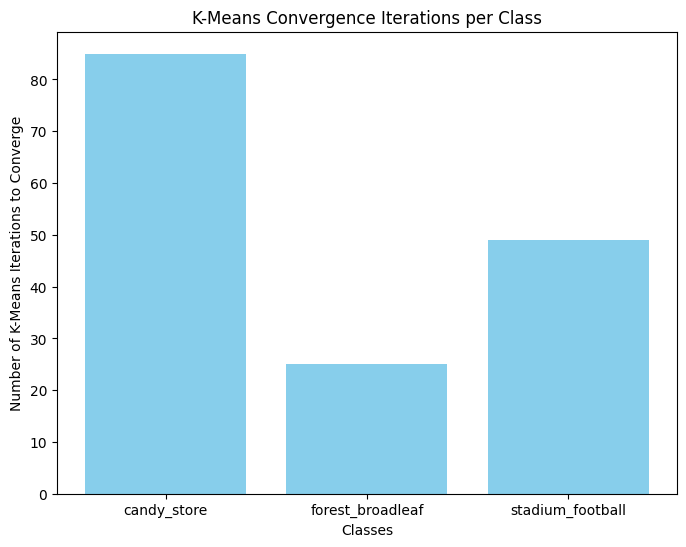


Starting GMM Training with EM Algorithm...

Classifying Test Images...

Classification Accuracy: 60.67%

Confusion Matrix:
                                    Predicted
               candy_store forest_broadleaf stadium_football
candy_store    38         0          12        
forest_broadleaf12         8          30        
stadium_football5          0          45        

Precision and Recall per Class:
candy_store: Precision = 0.69, Recall = 0.76
forest_broadleaf: Precision = 1.00, Recall = 0.16
stadium_football: Precision = 0.52, Recall = 0.90


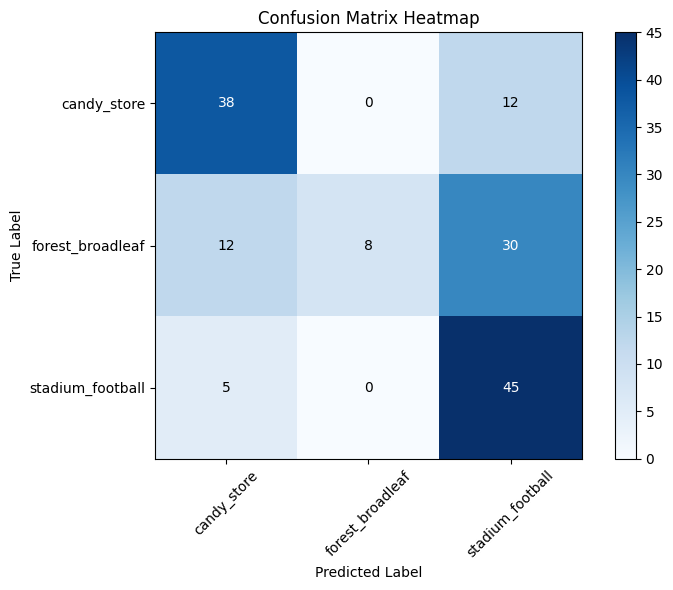

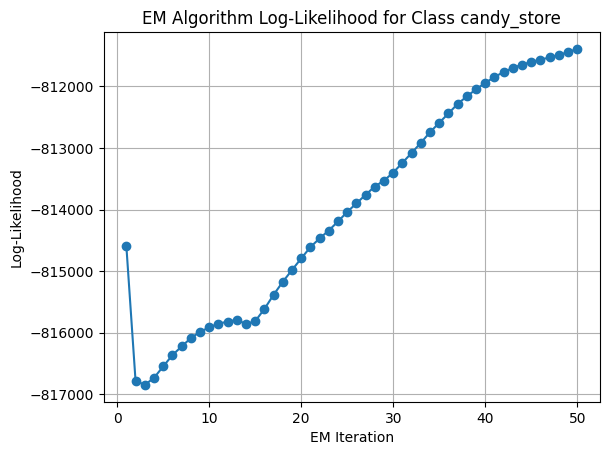

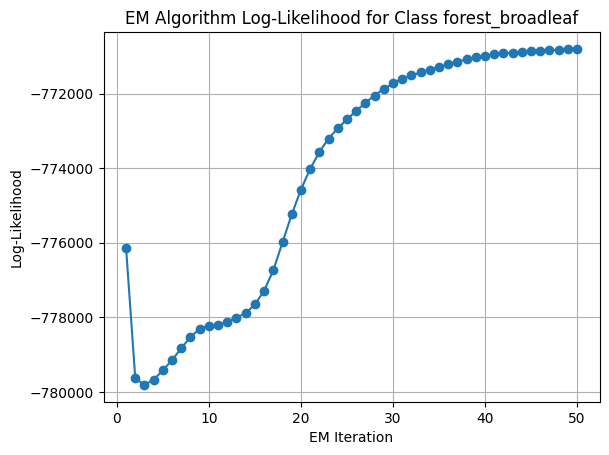

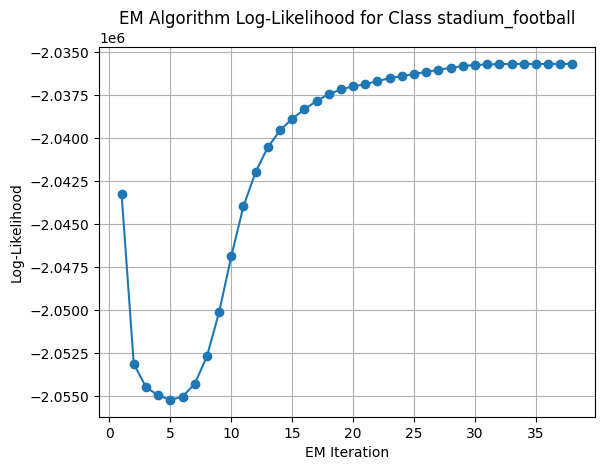

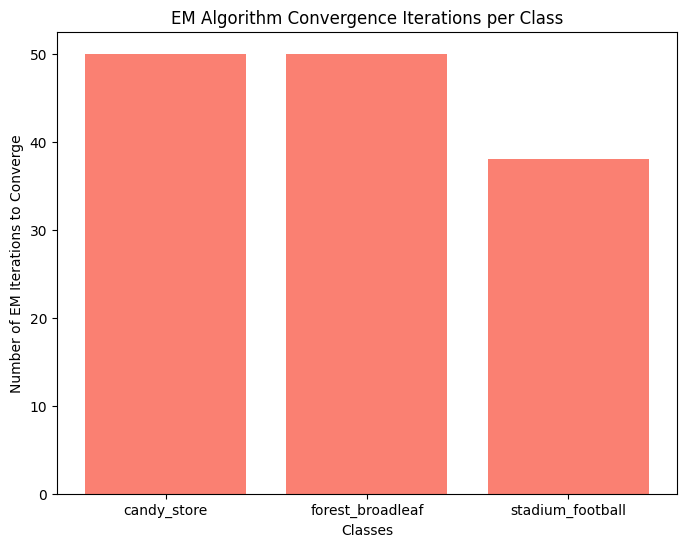

For K value  8

Starting K-Means Clustering on Training Data...


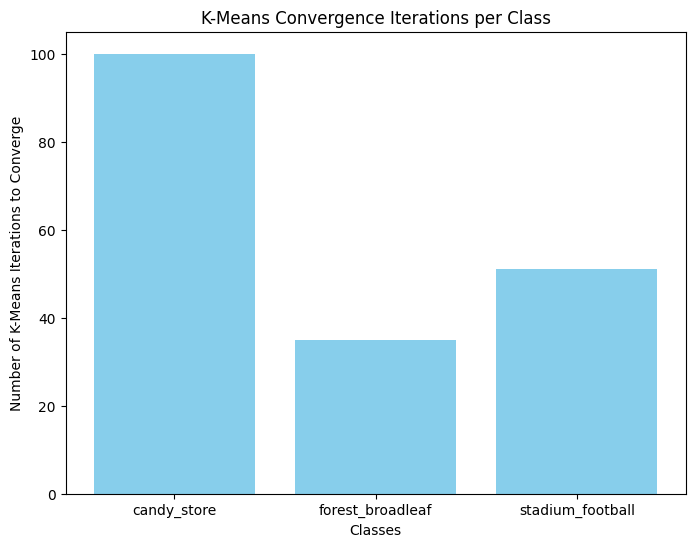


Starting GMM Training with EM Algorithm...


In [ ]:
def main():
    # Define paths and classes
    train_folder = 'train'
    test_folder = 'test'
    class_folders = ['candy_store', 'forest_broadleaf', 'stadium_football']
    
    # Process training and testing data
    print("Processing training data...")
    train_data = process_images_in_folder(train_folder, class_folders)
    print("Processing testing data...")
    test_data = process_images_in_folder(test_folder, class_folders)
    
    # Define number of clusters/GMM components
    K_set= [2,4,8]# You can adjust this based on your data
    
    for K in K_set:
        print("For K value ",K)
        print("\nStarting K-Means Clustering on Training Data...")
        class_centroids, class_assignments, class_iterations = perform_kmeans_on_train_data(train_data, K)
        classes = list(class_iterations.keys())
        iterations = list(class_iterations.values())
        
        plt.figure(figsize=(8, 6))
        plt.bar(classes, iterations, color='skyblue')
        plt.xlabel('Classes')
        plt.ylabel('Number of K-Means Iterations to Converge')
        plt.title('K-Means Convergence Iterations per Class')
        plt.show()
        
        # Train GMMs using the EM algorithm
        print("\nStarting GMM Training with EM Algorithm...")
        class_gmms, class_log_likelihoods, class_em_iterations = train_gmms(
            train_data,
            class_centroids,
            class_assignments,
            K,
            max_iters=50,
            tol=1e-1
        )
        
        # Classify test images
        print("\nClassifying Test Images...")
        true_labels, predicted_labels = evaluate_classifier(test_data, class_gmms, K)
        
        # Define class names
        classes = ['candy_store', 'forest_broadleaf', 'stadium_football']
        
        # Compute Evaluation Metrics
        accuracy = compute_accuracy(true_labels, predicted_labels)
        conf_matrix = compute_confusion_matrix(true_labels, predicted_labels, classes)
        precision, recall = compute_precision_recall(conf_matrix)
        
        # Display Metrics
        print(f"\nClassification Accuracy: {accuracy * 100:.2f}%\n")
        
        print("Confusion Matrix:")
        print(f"{'':15}{'Predicted':>30}")
        header = ' '.join([cls.ljust(10) for cls in classes])
        print(f"{'':15}{header}")
        for i, cls in enumerate(classes):
            row = ' '.join([str(conf_matrix[i, j]).ljust(10) for j in range(len(classes))])
            print(f"{cls.ljust(15)}{row}")
        
        print("\nPrecision and Recall per Class:")
        for i, cls in enumerate(classes):
            print(f"{cls}: Precision = {precision[i]:.2f}, Recall = {recall[i]:.2f}")
        
        # Plot Confusion Matrix Heatmap
        plot_confusion_matrix_heatmap(conf_matrix, classes)
        
        # Plot EM Log-Likelihoods for each class
        for cls, log_likelihood in class_log_likelihoods.items():
            plt.figure()
            plt.plot(range(1, len(log_likelihood)+1), log_likelihood, marker='o')
            plt.xlabel('EM Iteration')
            plt.ylabel('Log-Likelihood')
            plt.title(f'EM Algorithm Log-Likelihood for Class {cls}')
            plt.grid(True)
            plt.show()
        
        # Plot EM iterations per class
        plt.figure(figsize=(8, 6))
        plt.bar(classes, list(class_em_iterations.values()), color='salmon')
        plt.xlabel('Classes')
        plt.ylabel('Number of EM Iterations to Converge')
        plt.title('EM Algorithm Convergence Iterations per Class')
        plt.show()

if __name__ == "__main__":
    main()